---
---

# Team B.I.G

---
---

Submitted by:

 Vivek Venkateshprasad \
 862468868 \
 vv002

 Prathik Somanath \
 862467832 \
 psoma005
 
 Shubhank Joshi \
 862467912 \
 sjosh052
 
 
 Kyle Russell \
 862302220 \
 kruss020
  

 ---
 ---

Contributions of each team member

 Vivek Venkateshprasad - Data Cleaning(State Mapping), Geospatial analysis , DBSCAN, Holiday trends

 Prathik Somanath - Data Cleaning(Filtering and Groupby), Temporal analysis, DBSCAN, Holiday trends

 Shubhank Joshi - Data Cleaning(Exploratory data analysis), Heatmap generation, Correlation analysis

 Kyle Russell - Data Cleaning(Holiday Split), Choropleth maps, Correlation analysis

---

### Step 1: Downloading the dataset and performing Basic Cleaning

---


We download the accident dataset.

~~Only problem is ... Our accident dataset is Huuuuge, 7.7 Million Records Huge. None of our local computer could run this. So, we decided to use a smaller version of our dataset.~~

~~https://huggingface.co/datasets/nateraw/us-accidents~~

We managed to condense the large dataset to use it to account for the biased nature of the previous dataset


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("BigDataProcessing").getOrCreate()

# Load the CSV file with useful columns directly
useful_columns = ['State', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng']
acc_df = spark.read.csv("acc.csv", header=True, inferSchema=True).select(*useful_columns)

# Save the filtered data to a new file
acc_df.write.csv("data_filtered.csv", header=True, mode="overwrite")


24/12/10 16:05:39 WARN Utils: Your hostname, prathik-ThinkPad-T14-Gen-1 resolves to a loopback address: 127.0.1.1; using 192.168.1.50 instead (on interface wlp0s20f3)
24/12/10 16:05:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 16:05:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/10 16:05:51 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [2]:
# Load the processed data
data_df = spark.read.csv("data_filtered.csv", header=True, inferSchema=True)

# Show the first 5 rows
data_df.show(5)


+-----+--------+-------------------+-----------------+------------------+
|State|Severity|         Start_Time|        Start_Lat|         Start_Lng|
+-----+--------+-------------------+-----------------+------------------+
|   OH|       3|2016-02-08 05:46:00|        39.865147|        -84.058723|
|   OH|       2|2016-02-08 06:07:59|39.92805900000001|        -82.831184|
|   OH|       2|2016-02-08 06:49:27|        39.063148|        -84.032608|
|   OH|       3|2016-02-08 07:23:34|        39.747753|-84.20558199999998|
|   OH|       2|2016-02-08 07:39:07|        39.627781|        -84.188354|
+-----+--------+-------------------+-----------------+------------------+
only showing top 5 rows



We see that there are a lot columns which are not useful to us. We need to clean this data

Let us take a look at all the columns and determine which is useful to us

In [3]:
data_df.columns

['State', 'Severity', 'Start_Time', 'Start_Lat', 'Start_Lng']

In [4]:
useful_columns = ['State', 'Severity', 'Start_Time','Start_Lat','Start_Lng']
data_df = data_df.select(*useful_columns)
data_df.show(5)

+-----+--------+-------------------+-----------------+------------------+
|State|Severity|         Start_Time|        Start_Lat|         Start_Lng|
+-----+--------+-------------------+-----------------+------------------+
|   OH|       3|2016-02-08 05:46:00|        39.865147|        -84.058723|
|   OH|       2|2016-02-08 06:07:59|39.92805900000001|        -82.831184|
|   OH|       2|2016-02-08 06:49:27|        39.063148|        -84.032608|
|   OH|       3|2016-02-08 07:23:34|        39.747753|-84.20558199999998|
|   OH|       2|2016-02-08 07:39:07|        39.627781|        -84.188354|
+-----+--------+-------------------+-----------------+------------------+
only showing top 5 rows



Okay, that looks good. Now, we need to merge this with the accident dataset. Let us load that up from here:

https://www.gigasheet.com/sample-data/per-capita-us-alcohol-consumption

In [5]:
alcohol_df = spark.read.csv("alcohol.csv", header=True, inferSchema=True)
alcohol_df.show(5)

+----+-------+-------------+-------------------+------------------+------------------+--------------------------+--------------+------------------+--------------------------+--------------+----------------+----------------+---------------------------+
|Year|  State|Beverage_Type|Gallons_of_Beverage|Gallons_of_Ethanol|Population_14_Plus|Ethanol_Per_Capita_14_Plus|Decile_14_Plus|Population_21_Plus|Ethanol_Per_Capita_21_Plus|Decile_21_Plus|Data_Source_Type|Time_Varying_ABV|Gallons_of_Ethanol_from_ABV|
+----+-------+-------------+-------------------+------------------+------------------+--------------------------+--------------+------------------+--------------------------+--------------+----------------+----------------+---------------------------+
|1970|Alabama|      Spirits|            3863000|           1738350|            249900|                      6956|             9|            202000|                      8606|             9|               .|            NULL|                     

Let us look at the available columns in this dataset

In [6]:
alcohol_df.columns

['Year',
 'State',
 'Beverage_Type',
 'Gallons_of_Beverage',
 'Gallons_of_Ethanol',
 'Population_14_Plus',
 'Ethanol_Per_Capita_14_Plus',
 'Decile_14_Plus',
 'Population_21_Plus',
 'Ethanol_Per_Capita_21_Plus',
 'Decile_21_Plus',
 'Data_Source_Type',
 'Time_Varying_ABV',
 'Gallons_of_Ethanol_from_ABV']

We don't have any age groups mentioned in our dataset, so we need to remove it. We also do not care about how many beverages a person had. We just care about how drunk they got and that can be extracted from the "Gallons_of_ethanol" column. We also need to merge the populations and get the total population to get a new ethanol_per_capita column.

In [7]:
# Select useful columns
useful_columns = ['Year', 'State', 'Beverage_Type', 'Gallons_of_Ethanol', 'Population_14_Plus', 'Population_21_Plus']
alcohol_df = alcohol_df.select(*useful_columns)

# Show the first 5 rows
alcohol_df.show(5)

+----+-------+-------------+------------------+------------------+------------------+
|Year|  State|Beverage_Type|Gallons_of_Ethanol|Population_14_Plus|Population_21_Plus|
+----+-------+-------------+------------------+------------------+------------------+
|1970|Alabama|      Spirits|           1738350|            249900|            202000|
|1970|Alabama|         Wine|            225920|            249900|            202000|
|1970|Alabama|         Beer|           1489410|            249900|            202000|
|1970|Alabama|All Beverages|           3453680|            249900|            202000|
|1970| Alaska|      Spirits|            425250|             20500|             16500|
+----+-------+-------------+------------------+------------------+------------------+
only showing top 5 rows



We can immediately see a problem here. There is a semantic mismatch in the state names from the first column to the second.

For example, 

df1["State"] = "OH"

df2["State"] = "Ohio"

Let us fix this

I found this mapping dictionary here: https://gist.github.com/mshafrir/2646763

In [8]:
state_abbreviation_to_full_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon',
    'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
    'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

In [9]:
# data_df["State"] = data_df["State"].replace(state_abbreviation_to_full_name)
# data_df.head(5)

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a UDF to map abbreviations to full names
state_mapping_udf = udf(lambda abbr: state_abbreviation_to_full_name.get(abbr, abbr), StringType())

# Apply the mapping to the "State" column
data_df = data_df.withColumn("State", state_mapping_udf(col("State")))

# Show the updated DataFrame
# data_df.head(5)
data_df.show(5)

+-----+--------+-------------------+-----------------+------------------+
|State|Severity|         Start_Time|        Start_Lat|         Start_Lng|
+-----+--------+-------------------+-----------------+------------------+
| Ohio|       3|2016-02-08 05:46:00|        39.865147|        -84.058723|
| Ohio|       2|2016-02-08 06:07:59|39.92805900000001|        -82.831184|
| Ohio|       2|2016-02-08 06:49:27|        39.063148|        -84.032608|
| Ohio|       3|2016-02-08 07:23:34|        39.747753|-84.20558199999998|
| Ohio|       2|2016-02-08 07:39:07|        39.627781|        -84.188354|
+-----+--------+-------------------+-----------------+------------------+
only showing top 5 rows



Looks good. Now we need to add the popualtions of the two columns and create a new column just called "population" in the alcohol dataset. Then calculate the new ethanol per capita

In [10]:
from pyspark.sql.functions import col, lit, when, round, to_date, year, date_format

alcohol_df = alcohol_df.withColumn('Population', col('Population_14_Plus') + col('Population_21_Plus'))
alcohol_df = alcohol_df.withColumn('Ethanol_per_capita', round((col('Gallons_of_Ethanol') / col('Population')) * 1000))

alcohol_df = alcohol_df.drop('Population_14_Plus', 'Population_21_Plus')

alcohol_df.show(5)

+----+-------+-------------+------------------+----------+------------------+
|Year|  State|Beverage_Type|Gallons_of_Ethanol|Population|Ethanol_per_capita|
+----+-------+-------------+------------------+----------+------------------+
|1970|Alabama|      Spirits|           1738350|    451900|            3847.0|
|1970|Alabama|         Wine|            225920|    451900|             500.0|
|1970|Alabama|         Beer|           1489410|    451900|            3296.0|
|1970|Alabama|All Beverages|           3453680|    451900|            7643.0|
|1970| Alaska|      Spirits|            425250|     37000|           11493.0|
+----+-------+-------------+------------------+----------+------------------+
only showing top 5 rows



Okay, Now our accident dataset only is present from 2016 - 2021. So, all the data previous and after it is useless to us. Let us clean this out

In [11]:
alcohol_df = alcohol_df.filter((col('Year') > 2015) & (col('Year') < 2022))
alcohol_df.show(5)

+----+-------+-------------+------------------+----------+------------------+
|Year|  State|Beverage_Type|Gallons_of_Ethanol|Population|Ethanol_per_capita|
+----+-------+-------------+------------------+----------+------------------+
|2016|Alabama|      Spirits|           2631168|    760007|            3462.0|
|2016|Alabama|         Wine|           1043962|    760007|            1374.0|
|2016|Alabama|         Beer|           4401225|    760007|            5791.0|
|2016|Alabama|All Beverages|           8076355|    760007|           10627.0|
|2016| Alaska|      Spirits|            732610|    112306|            6523.0|
+----+-------+-------------+------------------+----------+------------------+
only showing top 5 rows



In [12]:
num_states = alcohol_df.select('State').distinct().count()
print(f'Number of unique states: {num_states}')

Number of unique states: 56


This doesn't seem right. Last time I checked there were 50 States + D.C. So why are there 56 entries ?

On closer inspection we see some data for 'Northeast Region', 'Midwest Region', 'South Region', 'West Region', 'United States' . We can drop these

In [13]:
states_to_drop = ['Northeast Region', 'Midwest Region', 'South Region', 'West Region', 'United States']
alcohol_df = alcohol_df.filter(~col('State').isin(states_to_drop))
num_states = alcohol_df.select('State').distinct().count()
print(f'Number of unique states: {num_states}')

Number of unique states: 51


This looks better.

This marks and end of our basic cleaning

---

### Step 2:
### Processing Data for visualizations and further analysis

---




#### Processing Accident Data by State and Year
This code snippet demonstrates how to process the accident data by converting date information, handling missing values, extracting year, and aggregating accident counts by state and year.

First, let us first fix the datetime format in our accident dataset

In [14]:
# df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed') # it has multiple datetime formats hence mixed
data_df = data_df.withColumn('Start_Time', to_date(col('Start_Time'), 'yyyy-MM-dd HH:mm:ss'))

# Create new columns for day of the week, date, and year
data_df = data_df.withColumn('Day_of_Week', date_format(col('Start_Time'), 'EEEE'))
data_df = data_df.withColumn('Date', col('Start_Time').cast('date'))
data_df = data_df.withColumn('Year', year(col('Start_Time')))
data_df = data_df.filter((col('Year') > 2015) & (col('Year') < 2022))
data_df.show(2)

+-----+--------+----------+-----------------+----------+-----------+----------+----+
|State|Severity|Start_Time|        Start_Lat| Start_Lng|Day_of_Week|      Date|Year|
+-----+--------+----------+-----------------+----------+-----------+----------+----+
| Ohio|       3|2016-02-08|        39.865147|-84.058723|     Monday|2016-02-08|2016|
| Ohio|       2|2016-02-08|39.92805900000001|-82.831184|     Monday|2016-02-08|2016|
+-----+--------+----------+-----------------+----------+-----------+----------+----+
only showing top 2 rows



Let us now count the accidents and group them by the state and year

In [15]:
accidents_by_state_and_year = data_df.groupBy('State', 'Year').count().withColumnRenamed('count', 'Accident_Count')
accidents_by_state_and_year.show(6)

+-------------+----+--------------+
|        State|Year|Accident_Count|
+-------------+----+--------------+
|     Maryland|2016|          7542|
|West Virginia|2017|           700|
|   California|2017|        152748|
|     Nebraska|2018|          5850|
|      Indiana|2018|         13708|
|         Iowa|2017|          3016|
+-------------+----+--------------+
only showing top 6 rows



#### Merging Alcohol Consumption and Accident Data by State and Year

This code snippet merges two datasets, one on alcohol consumption and the other on accident counts, by state and year. It then filters out regional aggregate rows, focusing on specific states.

In [16]:
merged_df = alcohol_df.join(accidents_by_state_and_year, on=['State', 'Year'], how='left').na.drop()

merged_df.show(5)


+-------------+----+-------------+------------------+----------+------------------+--------------+
|        State|Year|Beverage_Type|Gallons_of_Ethanol|Population|Ethanol_per_capita|Accident_Count|
+-------------+----+-------------+------------------+----------+------------------+--------------+
|     Maryland|2016|      Spirits|           4589620|    939751|            4884.0|          7542|
|     Maryland|2016|         Wine|           1987553|    939751|            2115.0|          7542|
|     Maryland|2016|         Beer|           4134870|    939751|            4400.0|          7542|
|     Maryland|2016|All Beverages|          10712042|    939751|           11399.0|          7542|
|West Virginia|2017|      Spirits|            708427|    291765|            2428.0|           700|
+-------------+----+-------------+------------------+----------+------------------+--------------+
only showing top 5 rows



In [17]:
#Let us take the data for all the beverages.
merged_df_all_beverages = merged_df.filter(col('Beverage_Type') == 'All Beverages')

merged_df_all_beverages.show(5)

+-------------+----+-------------+------------------+----------+------------------+--------------+
|        State|Year|Beverage_Type|Gallons_of_Ethanol|Population|Ethanol_per_capita|Accident_Count|
+-------------+----+-------------+------------------+----------+------------------+--------------+
|     Maryland|2016|All Beverages|          10712042|    939751|           11399.0|          7542|
|West Virginia|2017|All Beverages|           2670740|    291765|            9154.0|           700|
|   California|2017|All Beverages|          74831620|   6106431|           12255.0|        152748|
|     Nebraska|2018|All Beverages|           3378389|    292126|           11565.0|          5850|
|      Indiana|2018|All Beverages|          11785520|   1033008|           11409.0|         13708|
+-------------+----+-------------+------------------+----------+------------------+--------------+
only showing top 5 rows



Okay that's good. Way to go Arkansas you have very less accidents. However, we need to find out the accident per capita to get the true picture. Lets create a column for that

In [18]:
merged_df_all_beverages = merged_df_all_beverages.withColumn(
    'Accidents_per_capita', 
    round((col('Accident_Count') / col('Population')) * 10000)
)
merged_df_all_beverages.show(5)

+-------------+----+-------------+------------------+----------+------------------+--------------+--------------------+
|        State|Year|Beverage_Type|Gallons_of_Ethanol|Population|Ethanol_per_capita|Accident_Count|Accidents_per_capita|
+-------------+----+-------------+------------------+----------+------------------+--------------+--------------------+
|     Maryland|2016|All Beverages|          10712042|    939751|           11399.0|          7542|                80.0|
|West Virginia|2017|All Beverages|           2670740|    291765|            9154.0|           700|                24.0|
|   California|2017|All Beverages|          74831620|   6106431|           12255.0|        152748|               250.0|
|     Nebraska|2018|All Beverages|           3378389|    292126|           11565.0|          5850|               200.0|
|      Indiana|2018|All Beverages|          11785520|   1033008|           11409.0|         13708|               133.0|
+-------------+----+-------------+------

In [19]:
num_states = merged_df_all_beverages.select('State').distinct().count()
print(f'Number of unique states: {num_states}')

Number of unique states: 49


Seems like there are a couple of states missing. They are Hawaii and Alaska for the accidents.

Had to add a multiplier of 10000 because some states had way too few accidents compared to people. Still Arkansas looks to be doing well. Go Arkansas !

#### Holiday trend analysis 
Now we need to add more columns to our dataframe to analyze accident trends. Whether they have occured during holidays, which day of the week, etc.. 

In [20]:
import holidays
#this package will provide us the list of dates of holidays
for date, name in sorted(holidays.US(years=2024).items()):
    print(date, name)

2024-01-01 New Year's Day
2024-01-15 Martin Luther King Jr. Day
2024-02-19 Washington's Birthday
2024-05-27 Memorial Day
2024-06-19 Juneteenth National Independence Day
2024-07-04 Independence Day
2024-09-02 Labor Day
2024-11-11 Veterans Day
2024-11-28 Thanksgiving
2024-12-25 Christmas Day


In [21]:
# List of US holidays
from datetime import timedelta
us_holidays = holidays.US()

broadcast_us_holidays = spark.sparkContext.broadcast(us_holidays)

# UDF to determine holiday name (or nearby holiday name within -1, 0, +1 days)
def which_holiday(x):
    for i in [-1, 0, 1]:
        adjusted_date = x + timedelta(days=i)
        if adjusted_date in broadcast_us_holidays.value:
            return broadcast_us_holidays.value.get(adjusted_date)
    return None

which_holiday_udf = udf(which_holiday, StringType())

# Add Holiday Name column
data_df = data_df.withColumn("Holiday_Name", which_holiday_udf(col("Start_Time")))
data_df.show(5)

+-----+--------+----------+-----------------+------------------+-----------+----------+----+------------+
|State|Severity|Start_Time|        Start_Lat|         Start_Lng|Day_of_Week|      Date|Year|Holiday_Name|
+-----+--------+----------+-----------------+------------------+-----------+----------+----+------------+
| Ohio|       3|2016-02-08|        39.865147|        -84.058723|     Monday|2016-02-08|2016|        NULL|
| Ohio|       2|2016-02-08|39.92805900000001|        -82.831184|     Monday|2016-02-08|2016|        NULL|
| Ohio|       2|2016-02-08|        39.063148|        -84.032608|     Monday|2016-02-08|2016|        NULL|
| Ohio|       3|2016-02-08|        39.747753|-84.20558199999998|     Monday|2016-02-08|2016|        NULL|
| Ohio|       2|2016-02-08|        39.627781|        -84.188354|     Monday|2016-02-08|2016|        NULL|
+-----+--------+----------+-----------------+------------------+-----------+----------+----+------------+
only showing top 5 rows



In [22]:
holiday_df = data_df.filter(col("Holiday_Name") == "Christmas Day")
holiday_df.show(5)

+----------+--------+----------+---------+-------------------+-----------+----------+----+-------------+
|     State|Severity|Start_Time|Start_Lat|          Start_Lng|Day_of_Week|      Date|Year| Holiday_Name|
+----------+--------+----------+---------+-------------------+-----------+----------+----+-------------+
|California|       2|2016-12-24|38.823105|-123.02741999999999|   Saturday|2016-12-24|2016|Christmas Day|
|California|       3|2016-12-24|37.507172|-122.33852399999999|   Saturday|2016-12-24|2016|Christmas Day|
|California|       2|2016-12-24|37.724007|        -122.401474|   Saturday|2016-12-24|2016|Christmas Day|
|California|       2|2016-12-24|37.383385|        -122.069557|   Saturday|2016-12-24|2016|Christmas Day|
|California|       3|2016-12-24|37.317062|-121.94058999999999|   Saturday|2016-12-24|2016|Christmas Day|
+----------+--------+----------+---------+-------------------+-----------+----------+----+-------------+
only showing top 5 rows



#### Now our data is all clean and ready for visualizations. We can use these various datasets we have integrated to extract different type of information

---
---

# Data Visualization

*Note: There are some changes from the previous data cleaning ipynb. 
1. We have now added +1,-1 to the days to adjust for the holiday eves and when people might be travelling.
2. We have gathered data from a bigger dataset to account for the biased data present in our previous dataset.
3. Clearly pointed out that the population size is of the drinking population. Not the total.

Let us see which day has the most number of accidents on

In [23]:
import matplotlib.pyplot as plt

# Extract month-day from Date column
data_df = data_df.withColumn("Month-Day", date_format(col("Date"), "MM-dd"))

# Group by month-day and count occurrences
top_10_counts = (
    data_df.groupBy("Month-Day")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)

# Collect the data for visualization
top_10_counts_local = top_10_counts.toPandas()

holiday_counts = data_df.groupBy("Holiday_Name").count()

# Need to fix the data for nice visual on the graph
holiday_aliases = {
    "New Year's Day": "New Year's",
    "New Year's Day (observed)": "New Year's",
    "Christmas Day": "Christmas",
    "Christmas Day (observed)": "Christmas",
    "Juneteenth National Independence Day": "Juneteenth",
    "Juneteenth National Independence Day (observed)": "Juneteenth",
    "Martin Luther King Jr. Day": "MLK Jr. Day",
    "Washington's Birthday": "President's Day",
    "Veterans Day": "Veterans Day",
    "Veterans Day (observed)": "Veterans Day",
    "Independence Day": "Independence Day",
    "Independence Day (observed)": "Independence Day",
}

# Replace holiday names with aliases
for observed, alias in holiday_aliases.items():
    holiday_counts = holiday_counts.withColumn(
        "Holiday_Name",
        when(col("Holiday_Name") == observed, lit(alias)).otherwise(col("Holiday_Name"))
    )

# Aggregate the counts for combined holiday names
holiday_counts = holiday_counts.groupBy("Holiday_Name").sum("count").withColumnRenamed("sum(count)", "Accident_Count")


In [24]:
holiday_counts.show()

+----------------+--------------+
|    Holiday_Name|Accident_Count|
+----------------+--------------+
|      Juneteenth|         17588|
| President's Day|         44477|
|    Veterans Day|         72518|
|            NULL|       5284324|
|Independence Day|         38118|
|     MLK Jr. Day|         39224|
|       Christmas|         50328|
|      New Year's|         48662|
|    Thanksgiving|         54419|
|    Memorial Day|         31544|
|       Labor Day|         38107|
+----------------+--------------+



<Figure size 1000x600 with 0 Axes>

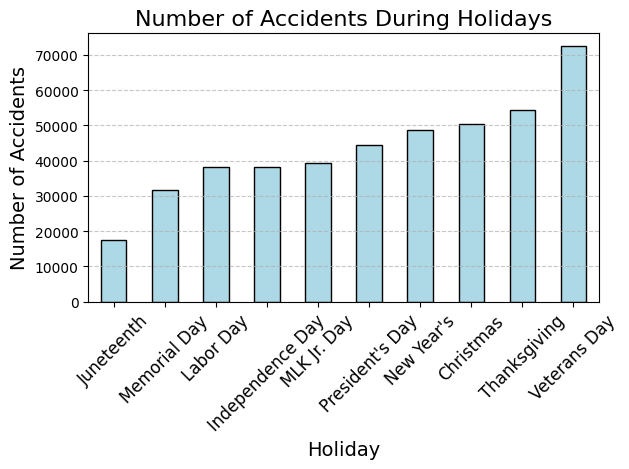

In [25]:
holiday_counts_local = holiday_counts.toPandas().dropna()

# Plot holiday accident counts
plt.figure(figsize=(10, 6))
holiday_counts_local.sort_values("Accident_Count", ascending=True).plot(
    kind='bar', 
    x="Holiday_Name", 
    y="Accident_Count",
    color='lightblue',
    legend=False,
    edgecolor='black'
)
plt.title("Number of Accidents During Holidays", fontsize=16)
plt.xlabel("Holiday", fontsize=14)
plt.ylabel("Number of Accidents", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This is interesting ... Veterans day seem to have the highest number of accidents.

Now, let's compare the average deaths during a holiday and average deaths during a non-holiday day. 

Here, the denominator to calculate the average for a non-holiday day is '333' because we have considered a 3 days for the holiday and there are a total of ~366 days in a year. So, the total number of non holiday days will be: 

366 - 33(11 holidays * 3 holidays each) = 333

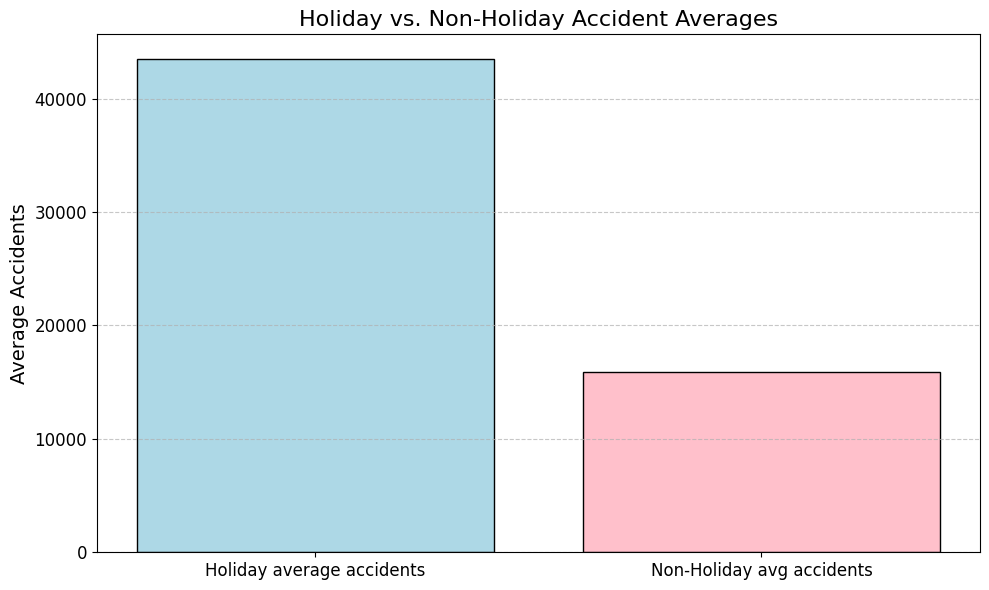

In [26]:
# Count non-holiday accidents
non_holiday_counts = data_df.filter(col("Holiday_Name").isNull()).count()

# Calculate averages
holiday_avg = holiday_counts_local["Accident_Count"].mean()
non_holiday_avg = non_holiday_counts / 333  # Adjust divisor based on your data

# Visualize holiday vs. non-holiday average accidents
plt.figure(figsize=(10, 6))
plt.bar(
    ["Holiday average accidents", "Non-Holiday avg accidents"],
    [holiday_avg, non_holiday_avg],
    color=['lightblue', 'pink'],
    edgecolor='black'
)
plt.title("Holiday vs. Non-Holiday Accident Averages", fontsize=16)
plt.ylabel("Average Accidents", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

We see a huge difference in accidents that have occured during holidays compared to normal days. This can be for a variety of reasons, let us see if one of the reasons can be alcohol consumption.

Let us see how alcohol actually correlates to the accidents in the US by visualising it on a map.

In [27]:
#for some reason plotly takes in only abbreviations
state_to_abbreviation = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY","District of Columbia":"DC"
}

state_mapping = spark.createDataFrame(list(state_to_abbreviation.items()), ["State", "Abbreviation"])

chloro_data_accidents = (
    merged_df_all_beverages.groupBy("State")
    .sum("Ethanol_per_capita", "Accidents_per_capita")
    .withColumnRenamed("sum(Ethanol_per_capita)", "Ethanol_per_capita")
    .withColumnRenamed("sum(Accidents_per_capita)", "Accidents_per_capita")
)

chloro_data_accidents = chloro_data_accidents.join(state_mapping, on="State", how="inner")

chloro_data_pd = chloro_data_accidents.toPandas()

In [28]:
import plotly.express as px

fig = px.choropleth(chloro_data_pd, locations='Abbreviation', color='Accidents_per_capita', scope="usa", locationmode="USA-states",title="Accidents per 10,000 drinking residents per state",hover_data="State")
 
fig.show()

In [29]:
import plotly.express as px

fig = px.choropleth(chloro_data_pd, locations='Abbreviation', color='Ethanol_per_capita', scope="usa", locationmode="USA-states",title="Ethanol per capita per state",hover_data="State")
 
fig.show()

Okay great, we can see which state has the most accidents and ethanol per capita. Now, we need to see if those two are correlated.
Below are the top ten States by accidents and Ethanol

In [30]:
from pyspark.sql.functions import rank
from pyspark.sql.window import Window

chloro_data_accidents = chloro_data_accidents.withColumn(
    "Accidents_Rank",
    rank().over(Window.orderBy(col("Accidents_per_capita").desc()))
).withColumn(
    "Ethanol_Rank",
    rank().over(Window.orderBy(col("Ethanol_per_capita").desc()))
)

chloro_data_rank_pd = chloro_data_accidents.toPandas()
acc_list = chloro_data_rank_pd.sort_values("Accidents_Rank")["State"].tolist()
eth_list = chloro_data_rank_pd.sort_values("Ethanol_Rank")["State"].tolist()


24/12/10 16:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:12:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 16:12:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/12/10 1

In [31]:
print("Top 10 States ranked by the number of Accidents per drinking residents")
acc_list[0:10]

Top 10 States ranked by the number of Accidents per drinking residents


['South Carolina',
 'Oregon',
 'California',
 'Florida',
 'Utah',
 'Minnesota',
 'Louisiana',
 'North Carolina',
 'Virginia',
 'Oklahoma']

In [32]:
print("Top 10 States ranked by the gallons of Ethanol consumed per drinking residents")
eth_list[0:10]

Top 10 States ranked by the gallons of Ethanol consumed per drinking residents


['New Hampshire',
 'District of Columbia',
 'Delaware',
 'Nevada',
 'North Dakota',
 'Montana',
 'Vermont',
 'Wisconsin',
 'Colorado',
 'Maine']

We can rank the states based on their accident and alchohol consumption and then find out if there is a correlation by plotting a scatterplot of their ranks in the two lists

In [33]:
acc_to_eth_list = [
    (state, acc_list.index(state), eth_list.index(state)) for state in acc_list
]
print(acc_to_eth_list)

[('South Carolina', 0, 37), ('Oregon', 1, 12), ('California', 2, 18), ('Florida', 3, 13), ('Utah', 4, 48), ('Minnesota', 5, 11), ('Louisiana', 6, 16), ('North Carolina', 7, 31), ('Virginia', 8, 36), ('Oklahoma', 9, 45), ('Tennessee', 10, 33), ('Arizona', 11, 27), ('Texas', 12, 25), ('Maryland', 13, 38), ('Alabama', 14, 43), ('Pennsylvania', 15, 26), ('District of Columbia', 16, 1), ('Nebraska', 17, 35), ('Rhode Island', 18, 14), ('Connecticut', 19, 20), ('Michigan', 20, 23), ('Georgia', 21, 44), ('New York', 22, 34), ('Washington', 23, 30), ('Colorado', 24, 8), ('Illinois', 25, 24), ('Montana', 26, 5), ('Delaware', 27, 2), ('New Jersey', 28, 21), ('Missouri', 29, 17), ('Massachusetts', 30, 15), ('Indiana', 31, 32), ('Ohio', 32, 40), ('New Hampshire', 33, 0), ('Iowa', 34, 22), ('Kentucky', 35, 41), ('Nevada', 36, 3), ('Idaho', 37, 39), ('Kansas', 38, 42), ('New Mexico', 39, 29), ('Wisconsin', 40, 7), ('Arkansas', 41, 46), ('West Virginia', 42, 47), ('Mississippi', 43, 28), ('North Dakot

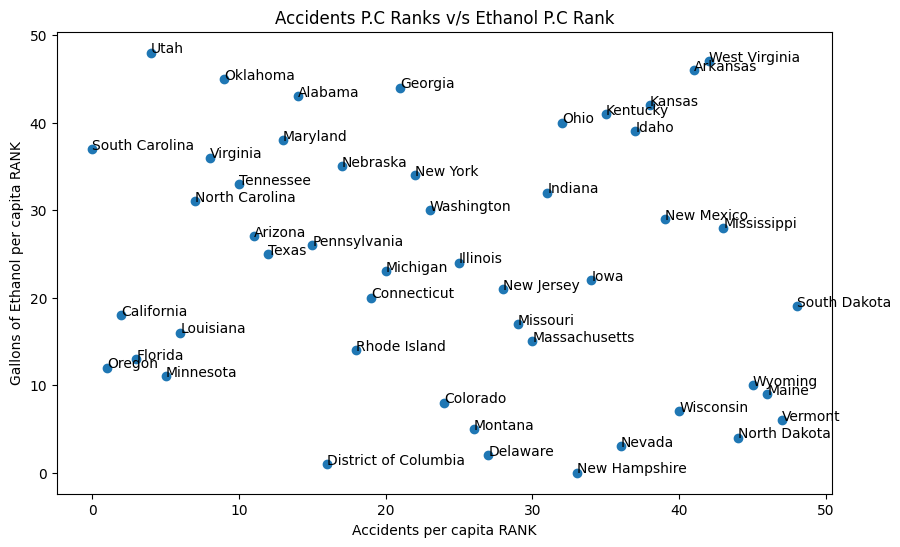

In [34]:
x = [x[1] for x in acc_to_eth_list]
y = [x[2] for x in acc_to_eth_list]
plt.figure(figsize=(10, 6))
plt.scatter(x,y)
plt.title("Accidents P.C Ranks v/s Ethanol P.C Rank")
plt.xlabel("Accidents per capita RANK")
plt.ylabel("Gallons of Ethanol per capita RANK")
# Add labels to each point
for i, name in enumerate([x[0] for x in acc_to_eth_list]):
    plt.annotate(name, (x[i], y[i]))

plt.show()

In [35]:
from scipy import stats
spearman_corr = stats.spearmanr(
    chloro_data_pd["Ethanol_per_capita"],
    chloro_data_pd["Accidents_per_capita"]
)
print("Spearman Correlation Coefficient:", spearman_corr.correlation)

Spearman Correlation Coefficient: -0.16204081632653058


Like we saw in the scatter plot, There is no correlation between the alcohol drinking states and the accident states.

We will not stop there. We might be able to get more patterns/insights out of our accidents dataset. We will try to plot a heatmap and see which day of the week more likely to have an accident.

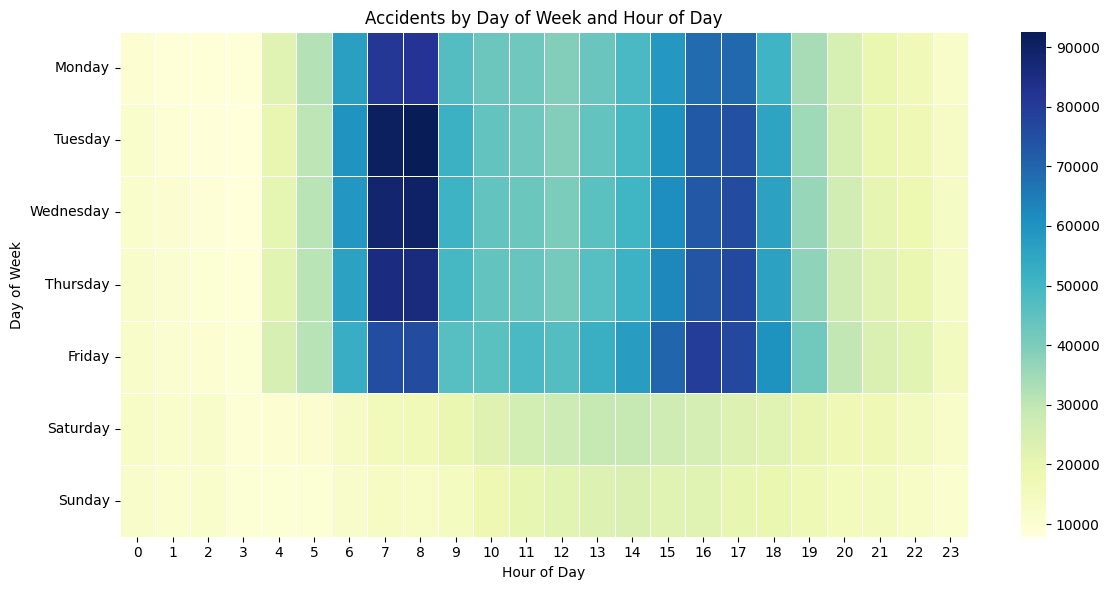

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("data.csv")
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed') # it has multiple datetime formats hence mixed

# Create new columns for day of the week, date, and year
df['Day_of_Week'] = df['Start_Time'].dt.day_name()      
df['Date'] = df['Start_Time'].dt.date                
df['Year'] = df['Start_Time'].dt.year 
df = df[(df['Year'] > 2015) & (df['Year'] < 2022)].reset_index(drop=True)
df.head(2)

# Convert Start_Time to datetime and extract the hour
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['Hour'] = df['Start_Time'].dt.hour

# Pivot the data to create a Day vs. Hour matrix
heatmap_data = df.pivot_table(index='Day_of_Week', columns='Hour', 
                              values='Severity', aggfunc='count', fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=False, fmt="d", linewidths=.5)
plt.title("Accidents by Day of Week and Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()

In the above heatmap we see that the accident mostly occurs during the weekdays and peak traffic rush hours.

In [38]:
import pandas as pd
import plotly.graph_objects as go
from pyspark.sql.functions import count, hour
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# # Aggregate data by year
aggregated_df = (
    merged_df_all_beverages.groupBy("Year")
    .agg(F.sum("Gallons_of_Ethanol").alias("Gallons_of_Ethanol"))
    .orderBy("Year")
)

aggregated_population_df = (
    data_df.groupBy("Year")
    .agg(count(lit(1)).alias("Population"))
    .orderBy("Year")
)

# Convert to Pandas for Plotly visualization
aggregated_df_pd = aggregated_df.toPandas()
aggregated_population_pd = aggregated_population_df.toPandas()

# Plotly: Alcohol Consumption Time Series
fig1 = go.Figure()
fig1.add_trace(
    go.Scatter(
        x=aggregated_df_pd['Year'],
        y=aggregated_df_pd['Gallons_of_Ethanol'],
        mode='lines+markers',
        name='Alcohol Consumption (Ethanol per capita)',
        line=dict(color='blue')
    )
)
fig1.update_layout(
    title='Time Series of Alcohol Consumption',
    xaxis_title='Year',
    yaxis_title='Gallons',
    legend_title='Metrics',
    template='plotly_white'
)
fig1.show()

# Plotly: Accidents Time Series
fig2 = go.Figure()
fig2.add_trace(
    go.Scatter(
        x=aggregated_population_pd['Year'],
        y=aggregated_population_pd['Population'],
        mode='lines+markers',
        name='Accidents',
        line=dict(color='red')
    )
)
fig2.update_layout(
    title='Time Series of Accidents',
    xaxis_title='Year',
    yaxis_title='People',
    legend_title='Metrics',
    template='plotly_white'
)
fig2.show()

We created time series charts to analyze the relationship between the number of accidents and the volume of alcohol consumption over time. The first chart illustrates the trend in the number of accidents over time, while the second chart captures the trend in gallons of alcohol consumed during the same period. By comparing these charts, we observed a noticeable pattern: as the gallons of alcohol consumed increased, there was a corresponding rise in the number of accidents.

Now that we have seen so many accidents, can we do anything about it? Yes we can.
We analyzed accident data in South Carolina, identifying over 80,000 unique accident spots. To address this and optimize the placement of speed radars, we applied the DBSCAN clustering algorithm.

In [39]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None 
# Filter data for 2021 and state "South Carolina"
state_df = data_df.filter((col("Year") == 2021) & (col("State") == "South Carolina"))
state_df_state = data_df.filter((col("Year") == 2021) & (col("State") == "South Carolina"))

# Select relevant columns
coordinates = state_df.select("Start_Lat", "Start_Lng").collect()
coordinates = [(row["Start_Lat"], row["Start_Lng"]) for row in coordinates]

# Scale coordinates
scaler = StandardScaler()
scaled_coordinates = scaler.fit_transform(coordinates)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.008, min_samples=2)
dbscan.fit(scaled_coordinates)

# Extract cluster labels
cluster_labels = dbscan.labels_

# Add cluster labels back to the DataFrame
cluster_df = spark.createDataFrame(
    [(coordinates[i][0], coordinates[i][1], int(cluster_labels[i])) for i in range(len(cluster_labels))],
    schema=["Start_Lat", "Start_Lng", "Cluster"]
)

# Join cluster labels with the original filtered data
state_df = state_df.join(cluster_df, on=["Start_Lat", "Start_Lng"], how="left")

# Calculate number of noise points
noise_count = state_df.filter(col("Cluster") == -1).count()

# Calculate number of clusters
unique_clusters = state_df.select("Cluster").distinct().rdd.flatMap(lambda x: x).collect()
n_clusters = len([cluster for cluster in unique_clusters if cluster != -1])

print(f"Total number of accidents occurred in the state: {state_df.count()}")
print(f"Number of clusters (excluding noise): {n_clusters}")
print(f"Number of noise points: {noise_count}")

state_df = state_df.withColumn("Cluster", when(col("Cluster") == -1, "Noise").otherwise(col("Cluster")))

Total number of accidents occurred in the state: 79651
Number of clusters (excluding noise): 5277
Number of noise points: 5161


In [40]:
# Convert to Pandas for visualization
state_cluster_df_pandas = state_df.toPandas()
state_df_state_pandas = state_df_state.toPandas()

import plotly.express as px

# Visualize clusters on a map
fig = px.scatter_mapbox(
    state_cluster_df_pandas,
    lat="Start_Lat",
    lon="Start_Lng",
    color="Cluster",  # Different colors for clusters
    hover_data={"Cluster": True},
    zoom=3,
    mapbox_style="carto-positron",
    title="DBSCAN Clustering of Accident Locations"
)

# Saving the csv for visualization
state_cluster_df_pandas.to_csv('map-viz/public/cluster_df.csv', mode='a', index=False)
state_df_state_pandas.to_csv('map-viz/public/state_df.csv', mode='a', index=False)


# Plotted this graph in React Web App
# Show the map
# fig.show()

DBSCAN groups nearby accident locations into clusters, allowing us to reduce the number of monitoring points to around 5,000 key checkpoints. These checkpoints represent dense areas of accidents, where installing speed radars can effectively enhance road safety by targeting high-risk zones. This approach ensures efficient resource allocation while potentially reducing accident rates. We have plotted the graph in React Web App.

We can also find out the average distance between all the accident points and the centroids so we can efficiently place the speed radars to reduce the accidents.

In [41]:
from geopy.distance import geodesic
from pyspark.sql.functions import col, mean, udf, lit
from pyspark.sql.types import DoubleType, StringType
state_df = state_df.filter(col("Cluster") != "Noise")  # Exclude noise

# Step 1: Compute Cluster Centroids
centroids_df = (
    state_df.groupBy("Cluster")
    .agg(
        mean("Start_Lat").alias("Centroid_Lat"),
        mean("Start_Lng").alias("Centroid_Lng")
    )
)

# Join the centroids back to the original DataFrame
state_with_centroids = state_df.join(centroids_df, on="Cluster", how="inner")

# Step 2: Define UDF to Calculate Geodesic Distance
def geodesic_distance(start_lat, start_lng, centroid_lat, centroid_lng):
    return geodesic((start_lat, start_lng), (centroid_lat, centroid_lng)).miles

geodesic_udf = udf(geodesic_distance, DoubleType())

# Add a column for distances to centroid
state_with_centroids = state_with_centroids.withColumn(
    "Distance_to_Centroid",
    geodesic_udf(
        col("Start_Lat"),
        col("Start_Lng"),
        col("Centroid_Lat"),
        col("Centroid_Lng")
    )
)

# Step 3: Calculate Average Distance per Cluster
avg_distances_df = (
    state_with_centroids.groupBy("Cluster")
    .agg(
        mean("Distance_to_Centroid").alias("Avg_Distance_miles"),
        mean("Centroid_Lat").alias("Lat"),
        mean("Centroid_Lng").alias("Long")
    )
)

In [42]:
avg_distances_pd = avg_distances_df.toPandas()
# Find the maximum average distance
max_distance = avg_distances_pd['Avg_Distance_miles'].max()
print(f"\nMaximum average distance from the checkpoint (Centroid): {(max_distance)} miles")


Maximum average distance from the checkpoint (Centroid): 11 miles
